In [1]:
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ETFunctions as et
import MathsUtilities as ms
%matplotlib inline
from cycler import cycler

In [2]:
#function to set up crop variables
def SetCropVariables(Crop,RootRate,CovOpt,Cultivar,Irrigation,MaxRootDepth):
    Simulations.ix[(CovOpt,Cultivar,Irrigation),'Cover'] = 0.0
    Simulations.ix[(CovOpt,Cultivar,Irrigation),'rootdepth'] = 0.0
    for date in Simulations.ix[(CovOpt,Cultivar,Irrigation),:].index:
        TtToday = Simulations.ix[(CovOpt,Cultivar,Irrigation,date),'Tt']
        if CovOpt == 'Model':
            if date < SowingDate:
                Simulations.ix[(CovOpt,Cultivar,Irrigation,date),'cover'] = 0.0
            else:
                if TtToday < CropCoeffs.ix[Crop,'Tt_Sen']:
                    Simulations.ix[(CovOpt,Cultivar,Irrigation,date),'cover'] = CropCoeffs.ix[Crop,'Ymax']/(1+np.exp(-(TtToday-CropCoeffs.ix[Crop,'Xo'])/CropCoeffs.ix[Crop,'b']))
                else:
                    if TtToday < CropCoeffs.ix[Crop,'Tt_Mat']:
                        SenRate = CropCoeffs.ix[Crop,'Ymax']/(CropCoeffs.ix[Crop,'Tt_Mat'] - CropCoeffs.ix[Crop,'Tt_Sen'])
                        Simulations.ix[(CovOpt,Cultivar,Irrigation,date),'cover'] = CropCoeffs.ix[Crop,'Ymax']-(TtToday - CropCoeffs.ix[Crop,'Tt_Sen'])*SenRate
                    else:
                        Simulations.ix[(CovOpt,Cultivar,Irrigation,date),'cover'] = 0;
        if CovOpt == 'Obs':
            try:
                Simulations.ix[(CovOpt,Cultivar,Irrigation,date),'cover'] = GreenCover.ix[date,(Cultivar,Irrigation)]
            except:
                Simulations.ix[(CovOpt,Cultivar,Irrigation,date),'cover'] = 0.0
            
        Simulations.ix[(CovOpt,Cultivar,Irrigation,date),'rootdepth']  = min(TtToday*RootRate,MaxRootDepth)
        try:
            Simulations.ix[(CovOpt,Cultivar,Irrigation,date),'height'] = Height.ix[date,(Cultivar,Irrigation)]
        except: 
            Simulations.ix[(CovOpt,Cultivar,Irrigation,date),'height'] = 0.02475
#Function to infiltrate rainfall
def doPrecipitation(date, Precip,CovOpt,Cultivar,Irrigation):
    Infiltration = Precip
    for depth in Depths:
        key = 'SW' + str(depth)
        yesterday = date - dt.timedelta(1)
        Capacity = SoilWaterParams.ix[(Cultivar,Irrigation,depth),'DUL']*SoilWaterParams.ix[(Cultivar,Irrigation,depth),'Thickness'] - Simulations.ix[(CovOpt,Cultivar,Irrigation,yesterday),key]
        Absorption = min(Capacity,Infiltration)
        Simulations.ix[(CovOpt,Cultivar,Irrigation,date),key] = Simulations.ix[(CovOpt,Cultivar,Irrigation,yesterday),key] + Absorption
        Infiltration -= Absorption
    Simulations.ix[(CovOpt,Cultivar,Irrigation,date),'Drainage'] = Infiltration

#Function to remove evaporation
def doEvaporation(date,ES,CovOpt,Cultivar,Irrigation):
    yesterday = date - dt.timedelta(1)
    for depth in Depths:
        key = 'SW' + str(depth)    
        EvapCap = (Simulations.ix[(CovOpt,Cultivar,Irrigation,yesterday),key] - SoilWaterParams.ix[(Cultivar,Irrigation,depth),'LL']*SoilWaterParams.ix[(Cultivar,Irrigation,depth),'Thickness'] ) * SoilWaterParams.ix[(Cultivar,Irrigation,depth),'erk']
        EvapAct = min(ES,EvapCap)
        Simulations.ix[(CovOpt,Cultivar,Irrigation,date),key] -= EvapAct

#Function to remove transpiration
def doTranspiration(date,ET,CovOpt,Cultivar,Irrigation):
    yesterday = date - dt.timedelta(1)
    TransDem = ET
    RootDepthToday = Simulations.ix[(CovOpt,Cultivar,Irrigation,date),'rootdepth']
    for depth in Depths:
        LayThi = SoilWaterParams.ix[(Cultivar,Irrigation,depth),'Thickness']
        if depth-LayThi < RootDepthToday: #Have the roots entered the layer
            if depth < RootDepthToday: #Have they gone right through the layer
                PropExplored = 1.0
            else: #they are partly through the currently layer
                PropExplored = (RootDepthToday-(depth-LayThi))/LayThi
            key = 'SW' + str(depth)
            Capacity = (Simulations.ix[(CovOpt,Cultivar,Irrigation,date),key] - (SoilWaterParams.ix[(Cultivar,Irrigation,depth),'LL'] * LayThi)) * SoilWaterParams.ix[(Cultivar,Irrigation,depth),'kl'] * PropExplored
            Uptake = min(TransDem,Capacity)
            Simulations.ix[(CovOpt,Cultivar,Irrigation,date),key] -= Uptake
            TransDem -= Uptake

In [3]:
# Set up the met file
MetData = pd.read_csv('lincoln.met',sep='\t',skiprows=[1],engine='python',index_col=0,parse_dates=True)
MetData.ix[:,'satvp']= [et.saturated_vapor_pressure(MetData.ix[x,'mean']) for x in range(MetData.index.size)]
MetData.ix[:,'RH'] = [(MetData.ix[x,'vp']/MetData.ix[x,'satvp'])*100 for x in range(MetData.index.size)]

In [4]:
#Set simulation dates and crop
StartDate = dt.datetime(2014,10,14)
SowingDate = dt.datetime(2014,10,15)
HarvestDate = dt.datetime(2015,2,15)
CropSown = 'Barley (Spring)'
DateIndex = MetData.ix[StartDate:HarvestDate].index

In [5]:
# Set up crop coefficient data
CropInfo = ['[Stover].CoverFunction.Expanding.SigCoverFunction.b.Value',
            '[Stover].CoverFunction.Expanding.SigCoverFunction.Xo.Value',
            '[Stover].CoverFunction.Expanding.SigCoverFunction.Ymax.Value',
            'TT_Sen',
            'TT_Mat',
            '[Root].MaximumRootDepth.Value']
CropCoeffNames = ['b','Xo','Ymax','Tt_Sen','Tt_Mat','MaxRootDepth']

#Crop coefficient data
CropImport = pd.read_excel('CropCoeff.xlsx',sheetname='CoreParams',index_col=0)
CropCoeffs = CropImport.ix[:,CropInfo]
CropCoeffs.columns = CropCoeffNames
RootRate = 1
GreenCoverData = pd.read_pickle('FPARGreenEstimated.pkl')
GreenCoverData.sort_index(axis=1,inplace=True)
GreenCoverObs = GreenCoverData.groupby(level=['Cultivar','Irrigation'],axis=1).mean()
GreenCover = GreenCoverObs.resample('1D').interpolate(method='time')
HeightData = pd.read_pickle('..\RainShelterBarley\DataFrames\Height.pkl')
HeightData.sort_index(axis=1,inplace=True)
HeightObs = HeightData.groupby(level=['Cultivar','Irrigation'],axis=1).mean()
Height = HeightObs.resample('1D').interpolate(method='time')
Height.replace(np.nan,0,inplace=True)

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: .resample() is now a deferred operation
use .resample(...).mean() instead of .resample(...)
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: .resample() is now a deferred operation
use .resample(...).mean() instead of .resample(...)


In [6]:
#Set up the irrigaation file
Irrigation = pd.read_pickle('Irrigation.pkl')
IrrigDates = Irrigation.sum(axis=1)>0
IrrigTabel = np.round(Irrigation.ix[IrrigDates,:].groupby(level=['Irrigation','Cultivar'],axis=1).mean())
#'Measured' irrigation is under because doesn't account for E loss on irrigation day
#Add 10 mm to each irrigation event to account for this
IrrigTabel.ix['2014-11-05':'2014-12-05'] = np.add(IrrigTabel.ix['2014-11-05':'2014-12-05'],10)
IrrigTabel.replace(10.0,0.0,inplace=True)
Irrigation = IrrigTabel.ix[DateIndex].fillna(0)

In [7]:
IrrigTabel

Irrigation  High         Low         Mid      
Cultivar    Dash Omaka  Dash Omaka  Dash Omaka
2014-11-11  17.0  18.0   0.0   0.0   0.0   0.0
2014-11-18  45.0  39.0   0.0   0.0   0.0   0.0
2014-11-26  46.0  51.0   0.0   0.0   0.0   0.0
2014-12-02  48.0  54.0  29.0  31.0  85.0  78.0
2014-12-10  33.0  35.0   0.0   0.0   0.0   0.0
2014-12-16  33.0  33.0   0.0   0.0   0.0   0.0
2014-12-23  43.0  46.0   0.0   0.0   0.0   0.0
2014-12-30  34.0  37.0   0.0   0.0  83.0  81.0
2015-01-06  70.0  79.0   0.0   0.0   0.0   0.0
2015-01-13  47.0  45.0   0.0   0.0   0.0   0.0
2015-01-14   0.0   1.0   0.0   0.0   0.0   0.0

In [8]:
ObsData = pd.read_pickle('SoilVWC.pkl')
Data = ObsData.ix['2014-11-05 08:00:00':'2015-02-11'].groupby(level=['Depth', 'Irrigation', 'Cultivar','Block'],axis=1).mean()
Data =  Data.dropna(axis=1, how = 'all')
Data.ix[:,'Hour'] = Data.index.hour
Data.ix[:, 'Date'] = Data.index.date
#Down sample data to mid night values
Data = Data.ix[Data.Hour == 23].groupby('Date').mean()
Cultivars = ['Dash','Omaka']
Irrigations = ['Low', 'Mid','High']
Blocks = ['1','2','3','4']
for irr in Irrigations:
    for cul in Cultivars:
        for blo in Blocks:
            Data.ix[:,('D1',irr,cul,blo)] = (Data.ix[:,('D1B',irr,cul,blo)] + Data.ix[:,('D1I',irr,cul,blo)])/2

#Calculate the water content of the soil profile by multiplying the volumetric water content by each layers
#depth and summing.  The 0-15 layers are divided by 2 to average the two readings
ProfileWater = Data.ix[:,'D1I'] * 150/2 + \
               Data.ix[:,'D1B'] * 150/2 + \
               Data.ix[:,'D2'] * 150 + \
               Data.ix[:,'D3'] * 300 + \
               Data.ix[:,'D4'] * 300 + \
               Data.ix[:,'D5'] * 300 + \
               Data.ix[:,'D6'] * 300 + \
               Data.ix[:,'D7'] * 300

In [9]:
# Set up the soil
Thicknesses = [150,150,300,300,300,300,300]
ObsLabs = ['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7']
Depths = np.cumsum(Thicknesses)
keys = []
for depth in Depths:
    keys.append('SW'+str(depth))
ParamIndex = pd.MultiIndex.from_product([Cultivars,Irrigations,Depths],names=['Cultivar','Irrigation','Depth'])
SoilWaterParams = pd.DataFrame(index=ParamIndex,columns = ['SAT','DUL','LL','kl','InitSWC','InitSW'])

Cult = 'Omaka'
Irrig = 'High'
SoilWaterParams.ix[(Cult,Irrig),'DUL'] = [0.38,0.36,0.36,0.36,0.37,0.35,0.38]
SoilWaterParams.ix[(Cult,Irrig),'LL'] = [0.06,0.09,0.15,0.15,0.15,0.15,0.15]
SoilWaterParams.ix[(Cult,Irrig),'InitSWC'] = [0.8,0.55,0.75,1,1,1,1]

Cult = 'Omaka'
Irrig = 'Mid'
SoilWaterParams.ix[(Cult,Irrig),'DUL'] = [0.39,0.36,0.36,0.33,0.3,0.41,0.31]
SoilWaterParams.ix[(Cult,Irrig),'LL'] = [0.06,0.09,0.15,0.15,0.15,0.15,0.15]
SoilWaterParams.ix[(Cult,Irrig),'InitSWC'] = [0.8,0.7,0.85,1,1,1,1]

Cult = 'Omaka'
Irrig = 'Low'
SoilWaterParams.ix[(Cult,Irrig),'DUL'] = [0.23,0.36,0.36,0.34,0.3,0.4,0.32]
SoilWaterParams.ix[(Cult,Irrig),'LL'] = [0.06,0.09,0.15,0.15,0.15,0.15,0.15]
SoilWaterParams.ix[(Cult,Irrig),'InitSWC'] = [1,0.75,0.8,1,1,1,1]

Cult = 'Dash'
Irrig = 'High'
SoilWaterParams.ix[(Cult,Irrig),'DUL'] = [0.36,0.36,0.36,0.36,0.35,0.39,0.39]
SoilWaterParams.ix[(Cult,Irrig),'LL'] = [0.06,0.09,0.15,0.15,0.15,0.15,0.15]
SoilWaterParams.ix[(Cult,Irrig),'InitSWC'] = [0.8,0.7,0.8,1,1,1,1]

Cult = 'Dash'
Irrig = 'Mid'
SoilWaterParams.ix[(Cult,Irrig),'DUL'] = [0.36,0.36,0.36,0.41,0.36,0.39,0.41]
SoilWaterParams.ix[(Cult,Irrig),'LL'] = [0.06,0.09,0.15,0.15,0.15,0.15,0.15]
SoilWaterParams.ix[(Cult,Irrig),'InitSWC'] = [0.8,0.7,0.8,1,1,1,1]

Cult = 'Dash'
Irrig = 'Low'
SoilWaterParams.ix[(Cult,Irrig),'DUL'] = [0.36,0.36,0.36,0.37,0.36,0.39,0.42]
SoilWaterParams.ix[(Cult,Irrig),'LL'] = [0.06,0.09,0.15,0.15,0.15,0.15,0.15]
SoilWaterParams.ix[(Cult,Irrig),'InitSWC'] = [0.8,0.6,0.9,1,1,1,1]

Treatments = pd.MultiIndex.from_product([Cultivars,Irrigations])
for treat in Treatments:
    SoilWaterParams.ix[treat,'Thickness'] = Thicknesses
    SoilWaterParams.ix[treat,'erk'] = [0.02,0.00,0,0,0,0,0]
    SoilWaterParams.ix[treat,'ObsLab'] = ObsLabs
    if treat[0] == 'Dash':
        SoilWaterParams.ix[treat,'kl'] = [0.1,0.1,0.1,0.1,0.08,0.08,0.08]
    if treat[0] == 'Omaka':
        SoilWaterParams.ix[treat,'kl'] = [0.1,0.1,0.06,0.06,0.01,0.003,0.002]
        
for layer in SoilWaterParams.index:
    SoilWaterParams.ix[layer,'InitSW'] = (SoilWaterParams.ix[layer,'LL'] + \
                                          (SoilWaterParams.ix[layer,'DUL'] - SoilWaterParams.ix[layer,'LL'])* \
                                          SoilWaterParams.ix[layer,'InitSWC']) * \
                                          SoilWaterParams.ix[layer,'Thickness']

C:\Anaconda\lib\site-packages\ipykernel\zmqshell.py:537: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


In [10]:
def GraphWatBal(CoverOpt,Irrig,Cult,fig,Treat):
    colours = ['r', 'b', 'g']
    
    plt.axes(axs[0][0])
    plt.plot(Simulations.ix[(CoverOpt,Cult,Irrig),'cover'],label='Cover',color=colours[Treat-1])
    plt.plot(Simulations.ix[(CoverOpt,Cult,Irrig),'rootdepth']/1000,label='Root Depth (m)',color = 'k')
    plt.plot(Simulations.ix[(CoverOpt,Cult,Irrig),'height'],'--',label='Height (m)',color=colours[Treat-1])
    plt.title('Crop variables')
    
    plt.axes(axs[0][1])
    Ind = ProfileWater.ix[:,(Irrig,Cult)].index
    Med = ProfileWater.ix[:,(Irrig,Cult)].median(axis=1)
    SEM = ProfileWater.ix[:,(Irrig,Cult)].std(axis=1)/np.sqrt(4)
    Upp = Med + SEM
    Low = Med - SEM
    plt.fill_between(Ind,Upp,Low,alpha=0.2,color=colours[Treat-1])
    plt.plot(Ind,Med,'o',mfc=colours[Treat-1],mec=colours[Treat-1],markersize=2)
    plt.plot(Simulations.ix[(CoverOpt,Cult,Irrig),keys].sum(axis=1),color=colours[Treat-1],lw=2)
    plt.title('Profile Water Content (mm)')
    
    row = 1
    col = 0
    for depth in Depths:
        key = 'SW' + str(depth)
        ObsKey = SoilWaterParams.ix[(Cult,Irrig,depth),'ObsLab']
        plt.axes(axs[row][col])
        Ind = Data.ix[:,(ObsKey,Irrig,Cult)].index
        Med = Data.ix[:,(ObsKey,Irrig,Cult)].median(axis=1)
        SEM = Data.ix[:,(ObsKey,Irrig,Cult)].std(axis=1)/np.sqrt(4)
        Upp = Med + SEM
        Low = Med - SEM
        plt.fill_between(Ind,Upp,Low,alpha=0.2, color=colours[Treat-1])
        plt.plot(Ind,Med,'o',mfc=colours[Treat-1],mec=colours[Treat-1],markersize=3)
        plt.plot(np.divide(Simulations.ix[(CoverOpt,Cult,Irrig),key],SoilWaterParams.ix[(Cult,Irrig,depth),'Thickness']),color=colours[Treat-1],lw=2)
        plt.title('Layer ' + str(depth) + ' mm depth')
        plt.ylim(0,0.45)
        
        col +=1
        if col == 2:
            row += 1
            col = 0
    
    plt.axes(axs[4][1])
    plt.plot(Simulations.ix[(CoverOpt,Cult,Irrig),'Drainage'].cumsum(),label='Cover',color=colours[Treat-1])
    plt.title('Drainage')   

C:\Anaconda\lib\site-packages\ipykernel\kernelbase.py:399: PerformanceWarning: indexing past lexsort depth may impact performance.
  user_expressions, allow_stdin)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:76: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
C:\Anaconda\lib\site-packages\ipykernel\ipkernel.py:208: PerformanceWarning: indexing past lexsort depth may impact performance.
  res = shell.run_cell(code, store_history=store_history, silent=silent)
C:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2714: PerformanceWarning: indexing past lexsort depth may impact performance.
  interactivity=interactivity, compiler=compiler, result=result)


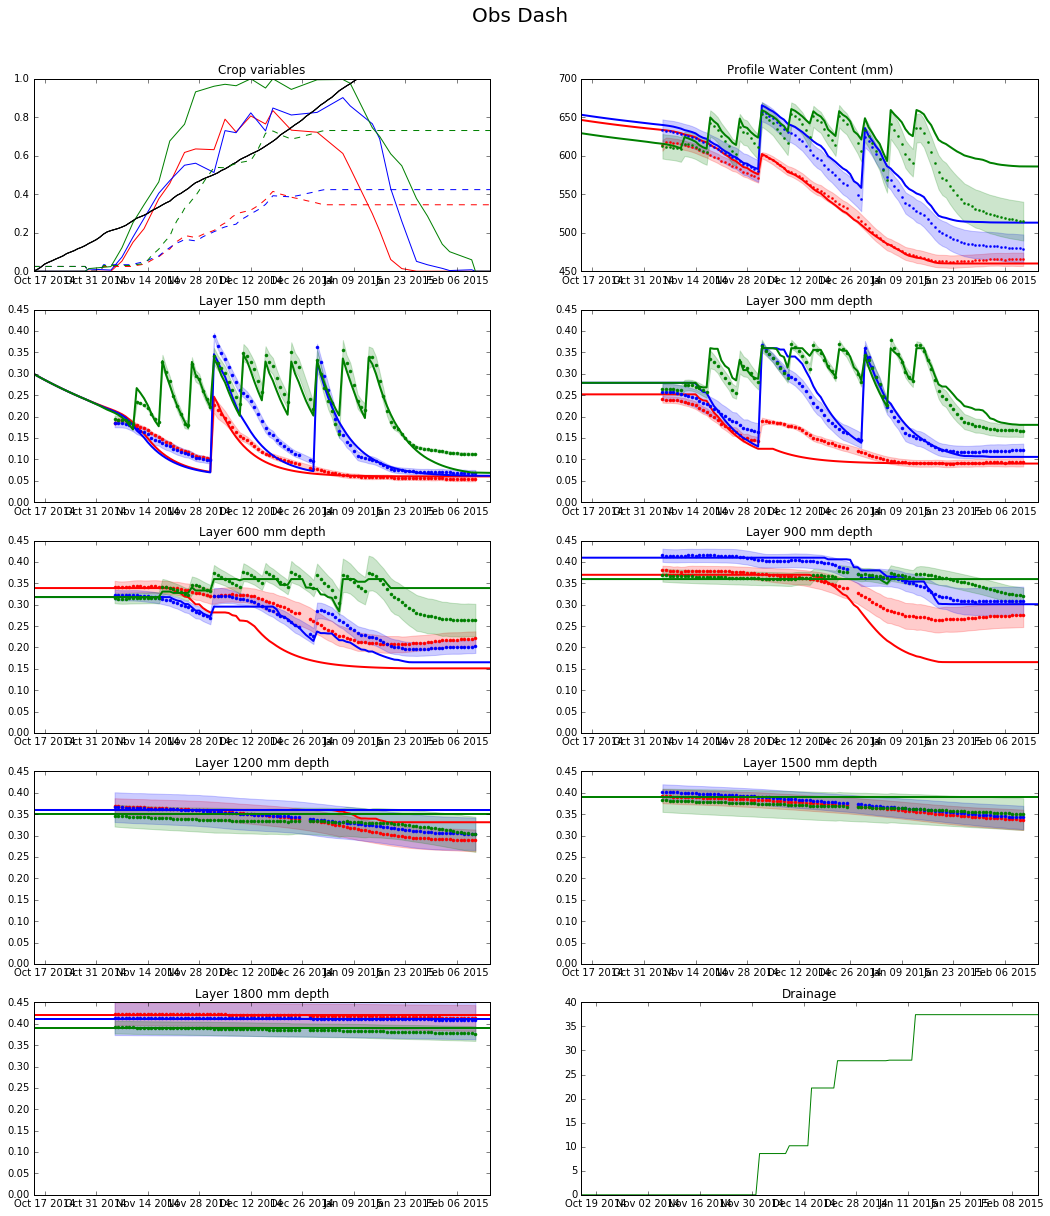

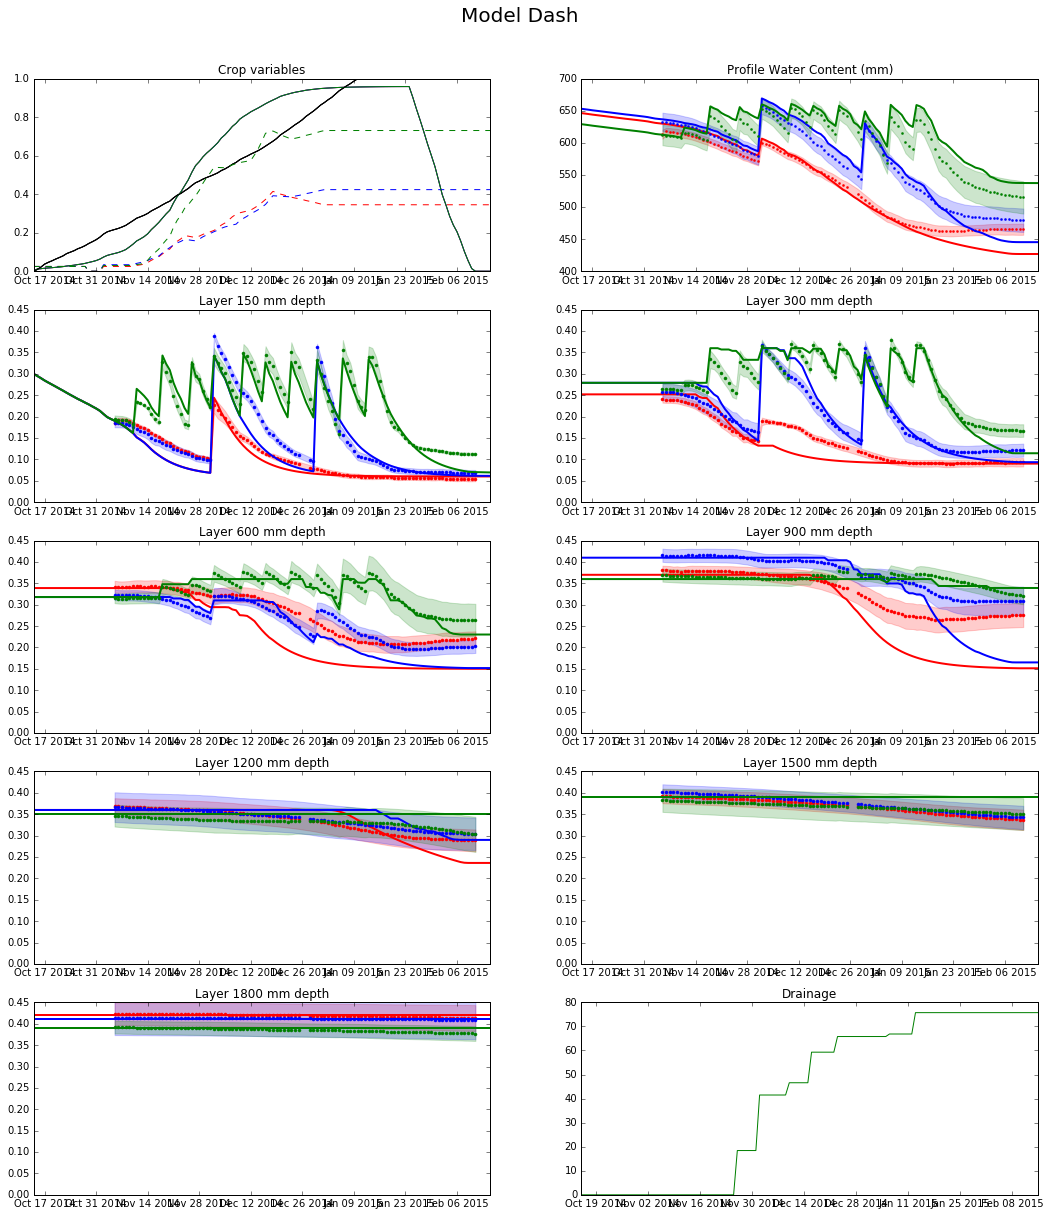

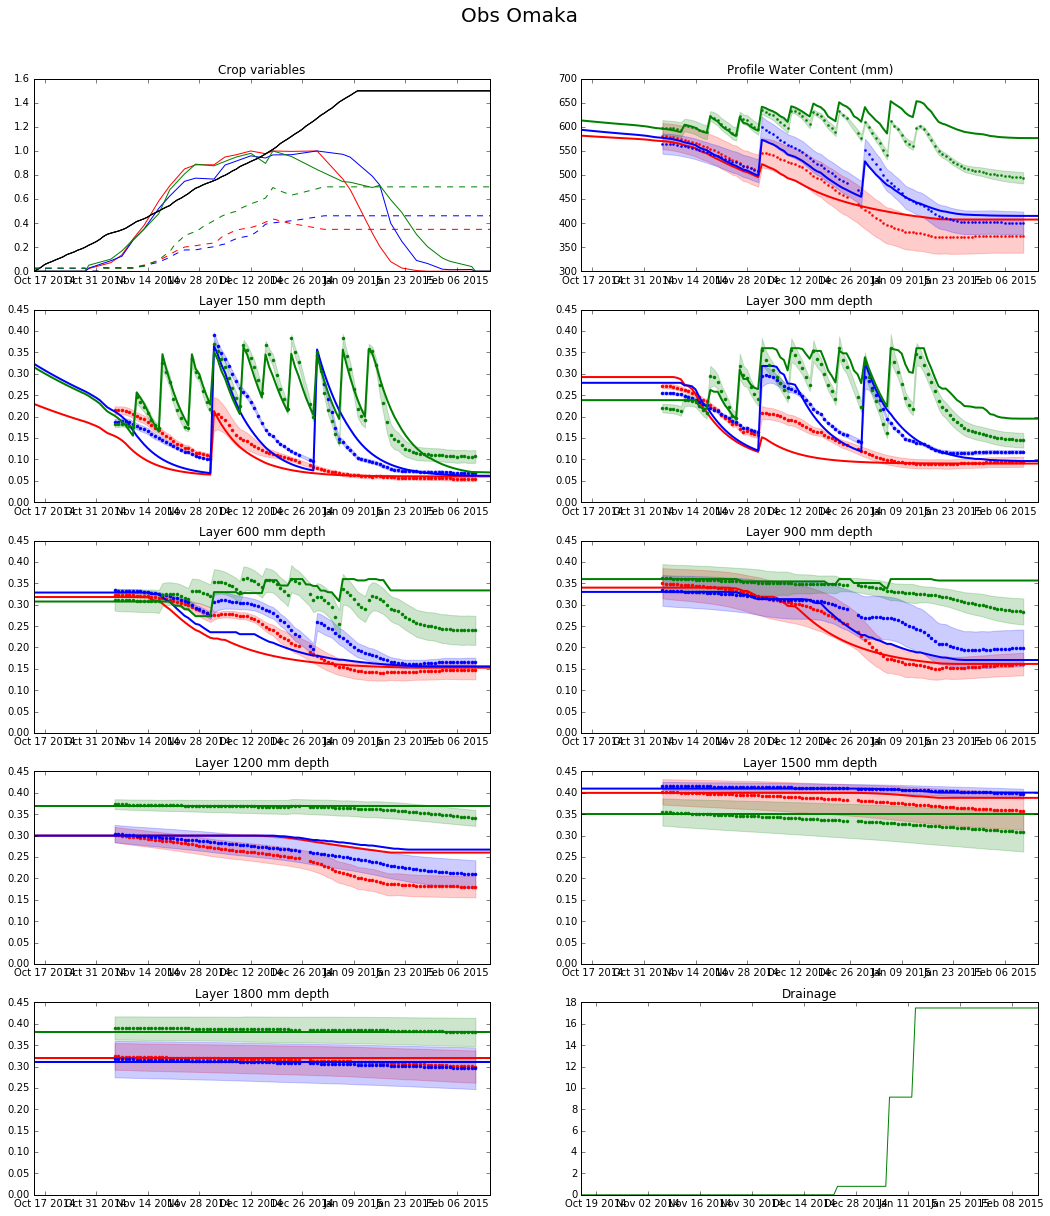

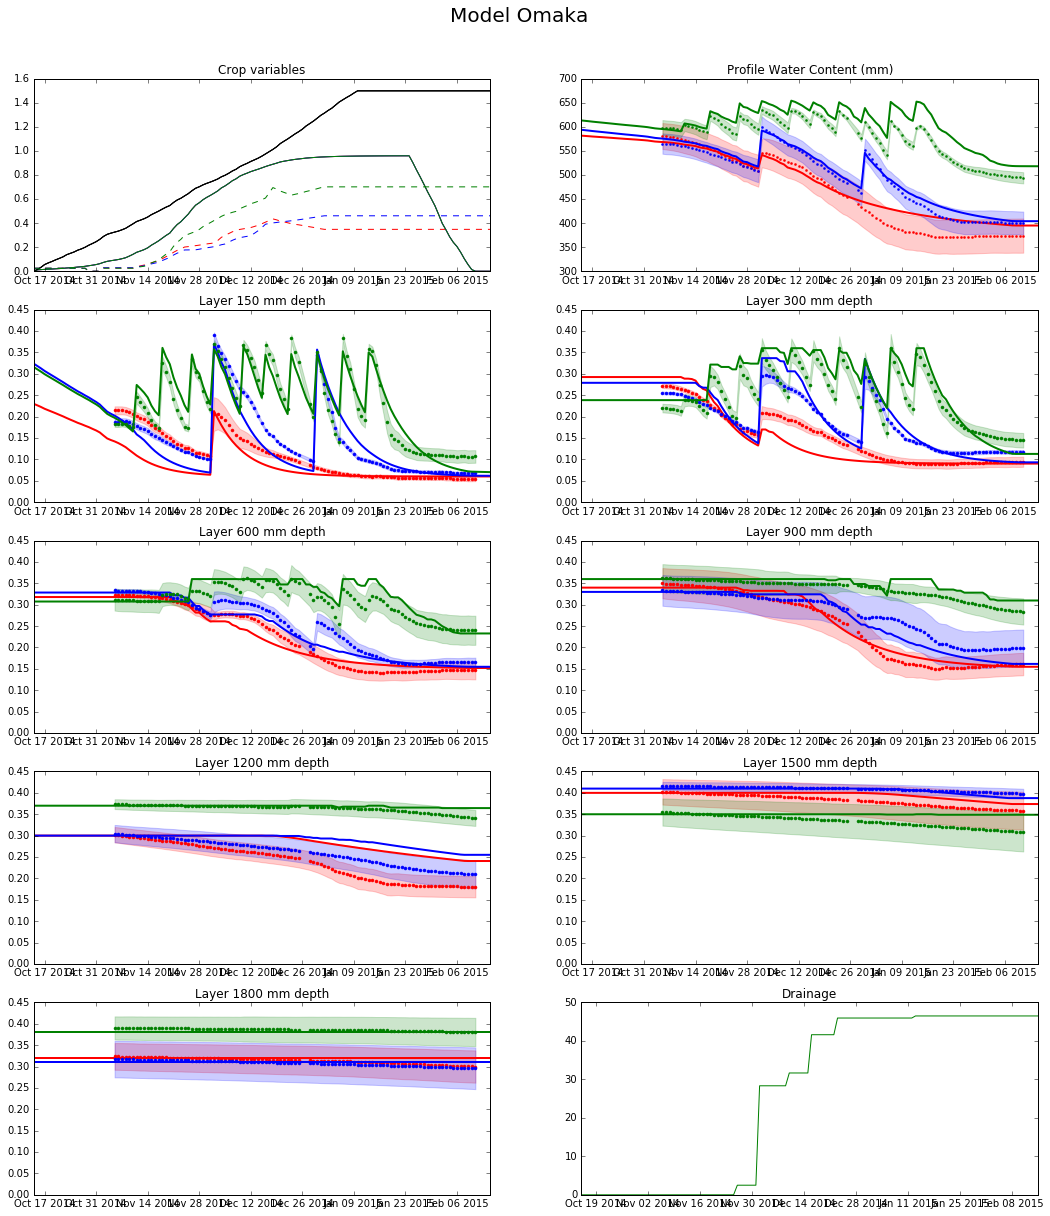

In [11]:
CoverOpts = ['Obs','Model']
#Make data frame to hold simulation results

Simulations = pd.DataFrame(index = pd.MultiIndex.from_product([CoverOpts,Cultivars,Irrigations,DateIndex],names = ['CoverMethod','Cultivar','Irrigation','Date']))

for Cult in Cultivars:
    for CoverOpt in CoverOpts:
        Treat = 1
        if Cult == 'Dash':
            RootRate = 0.8
            Kc = 1.3
            MaxRootDepth = 1000
        if Cult == 'Omaka':
            RootRate = 1.2
            Kc = 1.5
            MaxRootDepth = 1500
        for Irrig in Irrigations:    
            #Setup data structures
            Simulations.ix[(CoverOpt,Cult,Irrig),'Tt'] = 0.0
            Simulations.ix[(CoverOpt,Cult,Irrig),'Tt'].ix[SowingDate:HarvestDate] = MetData.ix[SowingDate:HarvestDate,'mean'].cumsum()
            
            #Set up crop variables
            SetCropVariables(CropSown,RootRate,CoverOpt,Cult,Irrig,MaxRootDepth)

            #Calculate potential evapotranspiration calcualtions
            for date in Simulations.ix[(CoverOpt,Cult,Irrig),:].index:
                Simulations.ix[(CoverOpt,Cult,Irrig,date),'ra'] = et.Ra(MetData.ix[date,'wind'],1.2,Simulations.ix[(CoverOpt,Cult,Irrig,date),'height'])
                Simulations.ix[(CoverOpt,Cult,Irrig,date),'NetRad'] = et.nett_radiation(MetData.ix[date,'radn'])
                Simulations.ix[(CoverOpt,Cult,Irrig,date),'EP'] = et.PenmanMonteith(Simulations.ix[(CoverOpt,Cult,Irrig,date),'NetRad'],MetData.ix[date,'mean'],MetData.ix[date,'RH'],MetData.ix[date,'wind'],Simulations.ix[(CoverOpt,Cult,Irrig,date),'ra'],70,86400)
                Simulations.ix[(CoverOpt,Cult,Irrig,date),'ES'] = Simulations.ix[(CoverOpt,Cult,Irrig,date),'EP'] * (1-Simulations.ix[(CoverOpt,Cult,Irrig,date),'cover']) 
                Simulations.ix[(CoverOpt,Cult,Irrig,date),'ET'] = Kc * Simulations.ix[(CoverOpt,Cult,Irrig,date),'EP'] * Simulations.ix[(CoverOpt,Cult,Irrig,date),'cover']

            #initialise soil water content on first day
            for depth in Depths:
                key = 'SW' + str(depth)
                Simulations.ix[(CoverOpt,Cult,Irrig,StartDate),key] = SoilWaterParams.ix[(Cult,Irrig,depth),'InitSW']

            #Calculate soil water balance on subsequent days
            for date in Simulations.ix[(CoverOpt,Cult,Irrig),:].index:
                if date > StartDate:
                    doPrecipitation(date, Irrigation.ix[date,(Irrig,Cult)],CoverOpt,Cult,Irrig)
                    doEvaporation(date,Simulations.ix[(CoverOpt,Cult,Irrig,date),'ES'],CoverOpt,Cult,Irrig)
                    doTranspiration(date,Simulations.ix[(CoverOpt,Cult,Irrig,date),'ET'],CoverOpt,Cult,Irrig)

            if Treat == 1:
                fig, axs = plt.subplots(5,2,figsize=(18,20))
                plt.suptitle(CoverOpt + ' ' + Cult, fontsize=20,y=0.95)
            GraphWatBal(CoverOpt,Irrig,Cult,fig,Treat)
            Treat += 1
        plt.show()

(array([ 735523.,  735537.,  735551.,  735565.,  735579.,  735593.,
         735607.,  735621.,  735635.]), <a list of 9 Text xticklabel objects>)

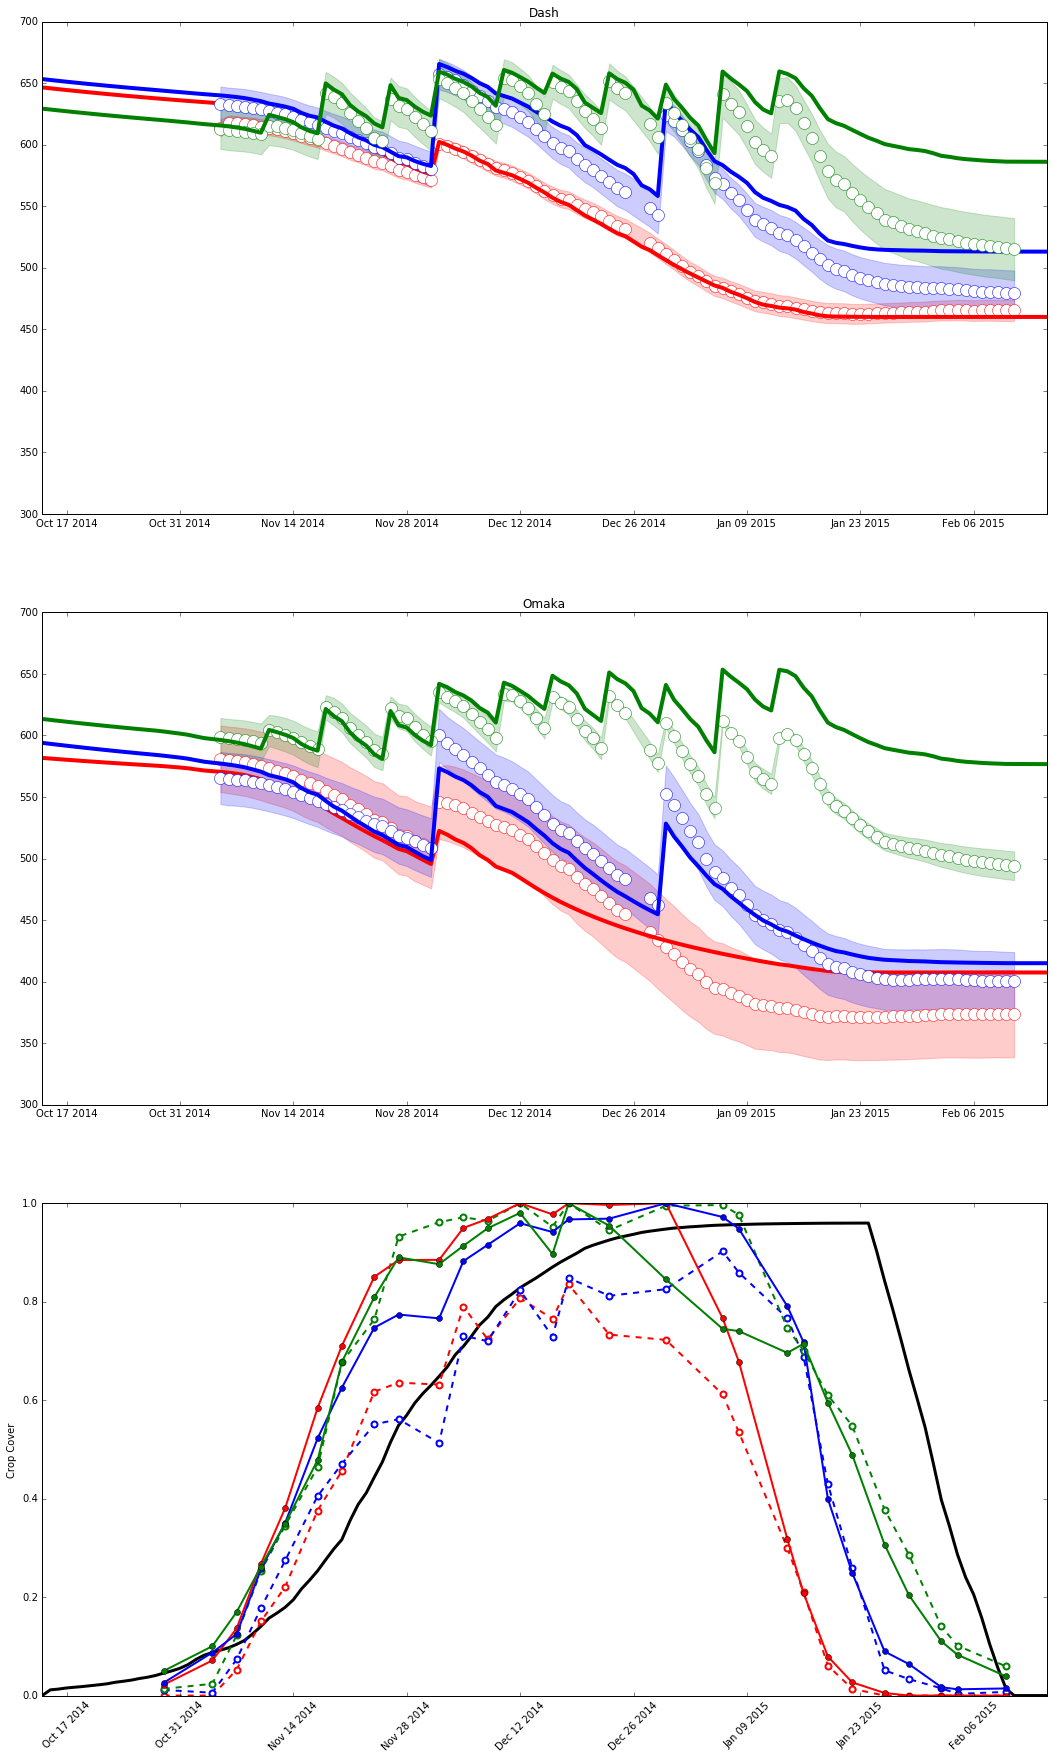

In [12]:
colours = ['r', 'b', 'g']
fig, axs = plt.subplots(3,1,figsize=(18,30))
plt.axes(axs[0])
Cult = 'Dash'
Treat = 1
for Irrig in Irrigations:
    Ind = ProfileWater.ix[:,(Irrig,Cult)].index
    Med = ProfileWater.ix[:,(Irrig,Cult)].median(axis=1)
    SEM = ProfileWater.ix[:,(Irrig,Cult)].std(axis=1)/np.sqrt(4)
    Upp = Med + SEM
    Low = Med - SEM
    plt.fill_between(Ind,Upp,Low,alpha=0.2,color=colours[Treat-1])
    plt.plot(Ind,Med,'o',mfc='w',mec=colours[Treat-1],markersize=12)
    plt.plot(Simulations.ix[('Obs',Cult,Irrig),keys].sum(axis=1),color=colours[Treat-1],lw=4)
    Treat +=1
plt.ylim(300,700)
plt.title(Cult)
plt.axes(axs[1])
Cult = 'Omaka'
Treat = 1
for Irrig in Irrigations:
    Ind = ProfileWater.ix[:,(Irrig,Cult)].index
    Med = ProfileWater.ix[:,(Irrig,Cult)].median(axis=1)
    SEM = ProfileWater.ix[:,(Irrig,Cult)].std(axis=1)/np.sqrt(4)
    Upp = Med + SEM
    Low = Med - SEM
    plt.fill_between(Ind,Upp,Low,alpha=0.2,color=colours[Treat-1])
    plt.plot(Ind,Med,'o',mfc='w',mec=colours[Treat-1],markersize=12)
    plt.plot(Simulations.ix[('Obs',Cult,Irrig),keys].sum(axis=1),color=colours[Treat-1],lw=4)
    Treat +=1
plt.title(Cult)
plt.ylim(300,700)

plt.axes(axs[2])
colours = ['r', 'b', 'g']
lines = ['--','-']
plt.plot(Simulations.ix[('Model','Dash','Low'),'cover'],label='AquaTrac',color='k', lw = 3)
CulPos = 0
for Cult in Cultivars:
    IrrPos = 0
    for Irrig in Irrigations:
        plt.plot(GreenCover.ix[:,(Cult,Irrig)], lines[CulPos],color=colours[IrrPos],lw=2)
        if Cult == 'Dash':
            plt.plot(GreenCoverObs.ix[:,(Cult,Irrig)],'o',color=colours[IrrPos], mec = colours[IrrPos], mfc='w',mew = 2)
        if Cult == 'Omaka':
            plt.plot(GreenCoverObs.ix[:,(Cult,Irrig)],'o',color=colours[IrrPos])
        IrrPos += 1
    CulPos += 1
plt.ylabel('Crop Cover')
plt.xticks(rotation=45)


(array([ 735523.,  735537.,  735551.,  735565.,  735579.,  735593.,
         735607.,  735621.,  735635.]), <a list of 9 Text xticklabel objects>)

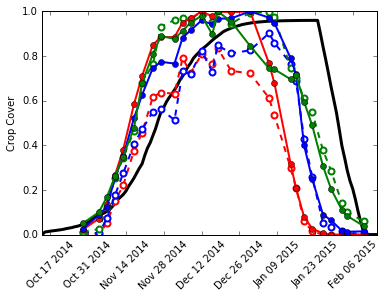

In [13]:
colours = ['r', 'b', 'g']
lines = ['--','-']
plt.plot(Simulations.ix[('Model','Dash','Low'),'cover'],label='AquaTrac',color='k', lw = 3)
CulPos = 0
for Cult in Cultivars:
    IrrPos = 0
    for Irrig in Irrigations:
        plt.plot(GreenCover.ix[:,(Cult,Irrig)], lines[CulPos],color=colours[IrrPos],lw=2)
        if Cult == 'Dash':
            plt.plot(GreenCoverObs.ix[:,(Cult,Irrig)],'o',color=colours[IrrPos], mec = colours[IrrPos], mfc='w',mew = 2)
        if Cult == 'Omaka':
            plt.plot(GreenCoverObs.ix[:,(Cult,Irrig)],'o',color=colours[IrrPos])
        IrrPos += 1
    CulPos += 1
plt.ylabel('Crop Cover')
plt.xticks(rotation=45)

In [14]:
#     Med2 = Med.resample('1D').mean()
#     start, end = Med2.index[0], Med2.index[-1]
#     RegStats = ms.MathUtilities.CalcRegressionStats('ET',Paddock.ix[start:end,keys].sum(axis=1),Med2)
#     Results = r'$R^2$ = ' + str(RegStats.R2)[:4]\
#         + '\n$Int$ = ' + str(RegStats.Intercept)[:4] \
#         + '\n$Slope$ = ' + str(RegStats.Slope)[:4]\
#         + '\n$NSE$ = ' + str(RegStats.NSE)[:4] +''
    
#     ylocation = Med2.min()
#     plt.text(Simulations.ix[(CoverOpt,Cult,Treat),:].index[0],ylocation,Results,fontsize=15)
